# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)

### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==2.0.0-alpha0**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Include paths to our functions

In [50]:
import sys
import os
import pathlib

workingdir=os.getcwd()
print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
    workingdir=str(pathlib.Path(workingdir).parents[0])
    print(workingdir)
    d=[d for d in os.listdir(str(workingdir))]
    n+=1
    if n>5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


## Setup librairies import and plots style

### Import librairies

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from absl import logging
from absl import flags
import seaborn as sns
import numpy as np
import itertools
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb, rgb2gray, label2rgb
import _pickle as cPickle
import lime
from lime import lime_image
from random import sample, randint, shuffle
import time
import shutil
import glob
import re
import codecs
import json 
import subprocess
import requests
import google.auth

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

2.0.0-dev20190426
2.2.4-tf


### Import our utils functions

In [4]:
import src.utils.mnist_utils as mnist_utils
import src.utils.ml_utils as ml_utils
import src.utils.tensorflow_helper as tensorflow_helper
import src.model_mnist_2_0_v1.trainer.model as mnist_v1

Current Working direcotory:	/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


In [57]:
import importlib
importlib.reload(mnist_utils)
importlib.reload(mnist_v1)
importlib.reload(ml_utils)
importlib.reload(tensorflow_helper);# to reload the function and mask the output

### Set plots style

In [6]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [7]:
# color code: https://matplotlib.org/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
plt.style.use('seaborn-ticks')

## Data visualization of some examples per classes

### Loading dataset

In [8]:
path_train='data/mnist/numpy_train/'
path_test='data/mnist/numpy_test/'
x_train=cPickle.load(open(path_train+'x_train.pkl', 'rb'))
y_train=cPickle.load(open(path_train+'y_train.pkl', 'rb'))
x_test=cPickle.load(open(path_test+'x_test.pkl', 'rb'))
y_test=cPickle.load(open(path_test+'y_test.pkl', 'rb'))

### Looking at some example from training dataset

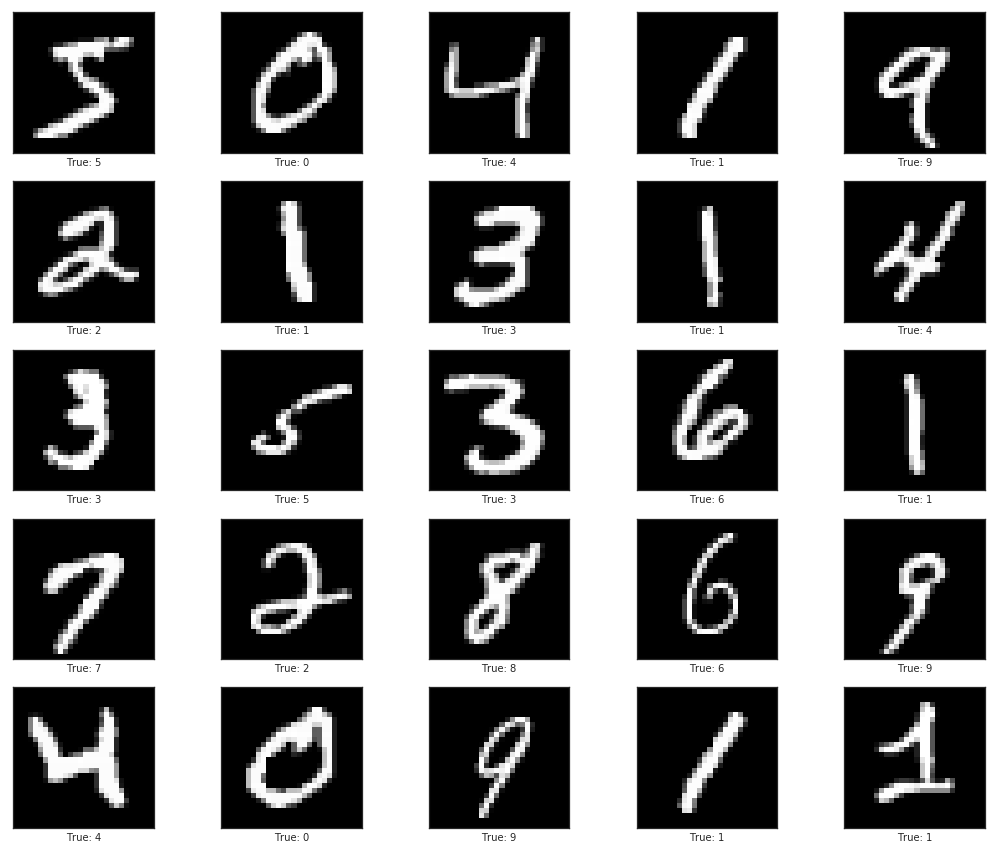

In [9]:
mnist_utils.plot_mnist_images(x_train[0:25], y_train[0:25])

## Set parameter

In [10]:
logging.set_verbosity(logging.INFO)
#logging.set_verbosity(logging.DEBUG)

In [11]:
# number of classes
NUM_CLASSES =10

# dimension of the input data
DIM_INPUT = 784

# number of epoch to train our model
EPOCHS = 100

# number of step to train our model
STEPS = 1000

# size of our mini batch
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = tf.data.experimental.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# model name
MODEL_NAME='model_mnist_v1'

# Model Version
MODEL_VERSION = 'v2'

# GCP project name, will be extracted later
PROJECT = ''

# Name of the bucket
BUCKET = 'cloud-training-demos-ml'

# GCP region
REGION = 'us-central1'

# GCP Scale Tier
TIER = 'BASIC'

# Training Directory name
TRAINING_DIR = 'mnist_trained'

# TensforFlow Version
TF_VERSION = '1.12'

# Labels
RESOURCE_LABELS='team=machine-learning,phase=test,owner=fabien'

In [12]:
os.environ['PROJECT'] = subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['BUCKET'] = os.environ['PROJECT']
os.environ['REGION'] = REGION
os.environ['TIER'] = TIER
os.environ['MODEL_NAME'] = MODEL_NAME
os.environ['MODEL_VERSION'] = MODEL_VERSION
os.environ['TRAINING_DIR'] = TRAINING_DIR 
os.environ['TFVERSION'] = TF_VERSION
os.environ['RESOURCE_LABELS'] = RESOURCE_LABELS

## Input dataset
Use tf.data.dataset to feed the Keras model

In [13]:
# be sure you have the tfrecords file locally if you want to train localy (or get them from Cloud Storage)
path_test_tfrecords = 'data/mnist/tfrecords_image_test/*'
path_train_tfrecords = 'data/mnist/tfrecords_image_train/*'

## Defined flags

In [14]:
print(flags.FLAGS)


absl.app:
  --[no]only_check_args: Set to true to validate args and exit.
    (default: 'false')
  --[no]pdb_post_mortem: Set to true to handle uncaught exceptions with PDB post
    mortem.
    (default: 'false')
  --profile_file: Dump profile information to a file (for python -m pstats).
    Implies --run_with_profiling.
  --[no]run_with_pdb: Set to true for PDB debug mode
    (default: 'false')
  --[no]run_with_profiling: Set to true for profiling the script. Execution will
    be slower, and the output format might change over time.
    (default: 'false')
  --[no]use_cprofile_for_profiling: Use cProfile instead of the profile module
    for profiling. This has no effect unless --run_with_profiling is set.
    (default: 'true')

absl.logging:
  --[no]alsologtostderr: also log to stderr?
    (default: 'false')
  --log_dir: directory to write logfiles into
    (default: '')
  --[no]logtostderr: Should only log to stderr?
    (default: 'false')
  --[no]showprefixforinfo: If False, do n

In [15]:
tf_flags=['f', 'input_train_tfrecords', 'input_test_tfrecords', 'model_dir', 'saved_dir', 'epoch', 'step', 'step_per_epoch', 'batch_size', 'shuffle_buffer_size', 'prefetch_buffer_size', 'num_parallel_calls', 'num_classes', 'dim_input']
tensorflow_helper.del_all_flags(flags.FLAGS, tf_flags)

In [16]:
# just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
flags.DEFINE_string('f', '', 'kernel') 

# path to input data
flags.DEFINE_string('input_train_tfrecords', path_train_tfrecords, 'input folder of tfrecords training data')
flags.DEFINE_string('input_test_tfrecords', path_test_tfrecords, 'input folder of tfrecords testing data')


# path to store the model and input for Tensorboard and SavedModel
flags.DEFINE_string('model_dir', 'results/Models/Mnist/tf_1_12/estimator/'+MODEL_VERSION+'/ckpt/', 'Dir to save a model and checkpoints')
flags.DEFINE_string('saved_dir', 'results/Models/Mnist/tf_1_12/estimator/'+MODEL_VERSION+'/pt/', 'Dir to save a model for TF serving')

# parameters for the input dataset and train the model
flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
flags.DEFINE_integer('step', STEPS, 'number of step')
flags.DEFINE_integer('step_per_epoch', len(x_train) // BATCH_SIZE, 'number of step per epoch')
flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')

# parameters for the model
flags.DEFINE_integer('num_classes', NUM_CLASSES, 'number of classes in our model')
flags.DEFINE_integer('dim_input', DIM_INPUT, 'dimension of the input data for our model')

FLAGS = flags.FLAGS

# new with 2.0
FLAGS(sys.argv)

['/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/ipykernel_launcher.py']

In [17]:
print(FLAGS)


/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --dim_input: dimension of the input data for our model
    (default: '784')
    (an integer)
  --epoch: number of epoch
    (default: '100')
    (an integer)
  --f: kernel
    (default: '')
  --input_test_tfrecords: input folder of tfrecords testing data
    (default: 'data/mnist/tfrecords_image_test/*')
  --input_train_tfrecords: input folder of tfrecords training data
    (default: 'data/mnist/tfrecords_image_train/*')
  --model_dir: Dir to save a model and checkpoints
    (default: 'results/Models/Mnist/tf_1_12/estimator/v2/ckpt/')
  --num_classes: number of classes in our model
    (default: '10')
    (an integer)
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '-1')
    (an integer)
  --saved_dir: Dir to save a mode

In [18]:
# pre defined flags
tf.estimator.ModeKeys.EVAL, tf.estimator.ModeKeys.PREDICT, tf.estimator.ModeKeys.TRAIN

('eval', 'infer', 'train')

### Printing the number relater to the number of events (epoch, batch size, ...)

In [19]:
def print_summary_input(data, step='training'):
    print('Summary for the {} dataset:'.format(step))
    if step=='training':
        print('  - number of epoch            :', FLAGS.epoch)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', FLAGS.batch_size)
        print('  - number of step per epoch   :', FLAGS.step_per_epoch)
        print('  - total number of steps      :', FLAGS.epoch * FLAGS.step_per_epoch)
    else:
        print('  - number of epoch            :', 1)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', None)
        print('  - number of step per epoch   :', 1)
        print('  - total number of steps      :', 1)  

In [20]:
print_summary_input(x_train)

Summary for the training dataset:
  - number of epoch            : 100
  - number of events per epoch : 60000
  - batch size                 : 128
  - number of step per epoch   : 468
  - total number of steps      : 46800


In [21]:
print_summary_input(x_test, 'testing')

Summary for the testing dataset:
  - number of epoch            : 1
  - number of events per epoch : 10000
  - batch size                 : None
  - number of step per epoch   : 1
  - total number of steps      : 1


## Machine Learning modelling with Keras

### Deleting existing models
delete fist the folder for a clean start

In [22]:
print('trained model will be saved here:\n', FLAGS.model_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/v2/ckpt/


In [23]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)

In [24]:
print('trained model will be saved here:\n', FLAGS.saved_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/v2/pt/


In [25]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

### Build the model

In [26]:
# reset the model
tf.keras.backend.clear_session()

In [27]:
# build the model
model_opt_tf = mnist_v1.keras_baseline_model(FLAGS.dim_input, FLAGS.num_classes)

# store the origina weights
initial_weights = model_opt_tf.get_weights()

keras_baseline_model


### Check the nuber of parameters

In [28]:
model_opt_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Check input and output layer names

In [29]:
model_opt_tf.input_names # Use this name as the dictionary key in the TF input function

['dense_input']

In [30]:
model_opt_tf.output_names

['dense_2']

### Use tf.distribute.startegy work across multiple devices/machines

In [31]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines
# works
strategy=None

# TF 2.0 bug 
# https://github.com/tensorflow/tensorflow/issues/27696
#strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()


# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=1,
                                         save_checkpoints_steps=100,
                                         keep_checkpoint_max=3,
                                         log_step_count_steps=10)

### Transform a keras model to estimator model

In [32]:
# Set to the original weights for testing other pipelines
model_opt_tf.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model_opt_tf,
                                                              config=training_config)

I0427 11:10:42.951343 4402439616 keras.py:432] Using the Keras model provided.
I0427 11:10:43.756482 4402439616 estimator.py:205] Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/v2/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 1, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3482e9b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas

## Training and inference using  tf.estimator and tf.data.dataset

- **batch_size** determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- **steps_per_epoch** the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- **validation_steps** similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



### Create some helper function

In [33]:
# need to be migrated to TF 2.0

Input dataset functions for training and testing will be pass during fit to load, convert, preprocess and reshuffle the images and labels 

### Train the  keras to estimator model locally

In [34]:
# drop all files except the keras folder before training
for x in glob.glob(FLAGS.model_dir+'*') :
    if 'keras' not in x:
        os.remove(x)

In [35]:
 for x in glob.glob(FLAGS.model_dir+'*') :
        print(x)

results/Models/Mnist/tf_1_12/estimator/v2/ckpt/keras


In [36]:
%%time
# need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()

# Fit the model (using estimator.train and data.Dataset)
estimator_train_model.train(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(path_train_tfrecords+'*',
                                                                                     FLAGS,
                                                                                     mode=tf.estimator.ModeKeys.TRAIN,
                                                                                     batch_size=FLAGS.batch_size),
                            steps=1000)

W0427 11:10:55.274463 4402439616 deprecation.py:323] From /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
I0427 11:10:55.283119 4402439616 model.py:211] input_dataset_fn: TRAIN, train
/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWarning: Creating resources inside a function passed to Dataset.flat_map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return filenames.flat_map(read_one_file)
I0427 11:10:55.334474 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:10:55.638467 4402439616 estimat

W0427 11:11:01.585448 4402439616 deprecation.py:323] From /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
I0427 11:11:01.676574 4402439616 basic_session_run_hooks.py:683] global_step/sec: 36.4439
I0427 11:11:01.678951 4402439616 basic_session_run_hooks.py:251] loss = 0.3623283, step = 300 (0.276 sec)
I0427 11:11:01.824713 4402439616 basic_session_run_hooks.py:683] global_step/sec: 67.4905
I0427 11:11:01.827288 4402439616 basic_session_run_hooks.py:251] loss = 0.331657, step = 310 (0.148 sec)
I0427 11:11:02.008049 4402439616 basic_session_run_hooks.py:683] global_step/sec: 54.5527
I0427 11:11:02.010259 4402439616 basic_session_run_hooks.py:251] loss = 0.43402937, step = 320 (0.183 sec)
I0427 11:11:02.2106

I0427 11:11:07.010420 4402439616 basic_session_run_hooks.py:251] loss = 0.3264287, step = 670 (0.117 sec)
I0427 11:11:07.139700 4402439616 basic_session_run_hooks.py:683] global_step/sec: 76.5978
I0427 11:11:07.141018 4402439616 basic_session_run_hooks.py:251] loss = 0.252872, step = 680 (0.131 sec)
I0427 11:11:07.252191 4402439616 basic_session_run_hooks.py:683] global_step/sec: 88.8961
I0427 11:11:07.253597 4402439616 basic_session_run_hooks.py:251] loss = 0.3877747, step = 690 (0.113 sec)
I0427 11:11:07.358061 4402439616 basic_session_run_hooks.py:597] Saving checkpoints for 700 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0427 11:11:07.489759 4402439616 basic_session_run_hooks.py:683] global_step/sec: 42.1037
I0427 11:11:07.491184 4402439616 basic_session_run_hooks.py:251] loss = 0.19293267, step = 700 (0.238 sec)
I0427 11:11:07.547661 4402439616 basic_session_run_hooks.py:683] global_step/sec: 172.881
I0427 11:11:07.549427 4402439616 basic_session_run_hooks.py:

CPU times: user 50.3 s, sys: 10.4 s, total: 1min
Wall time: 17.2 s


In [37]:
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/v2/ckpt/keras
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/events.out.tfevents.1556356255.Fabien-Tarrades-MacBook-Pro.local
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-900.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-900.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/graph.pbtxt
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-900.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-800.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-800.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-800.data-00000-of-00001


In [38]:
from google.protobuf import text_format


# Let's read our pbtxt file into a Graph protobuf
f = open(FLAGS.model_dir+'graph.pbtxt', "r")
graph_protobuf = text_format.Parse(f.read(), tf.compat.v1.GraphDef())

# Import the graph protobuf into our new graph.
graph_clone = tf.Graph()
with graph_clone.as_default():
    tf.import_graph_def(graph_def=graph_protobuf, name="")

# Display the graph inline.
graph_clone.as_graph_def()

node {
  name: "global_step/Initializer/zeros"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT64
        tensor_shape {
        }
        int64_val: 0
      }
    }
  }
}
node {
  name: "global_step"
  op: "VarHandleOp"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: "global_step"
    }
  }
}
node {
  name: "global_step/IsInitialized/VarIsInitializedOp"
  op: "VarIsInitializedOp"
  input: "global_step"
}
node {
  name: "global_step/Assign"
  op: "AssignVariableOp"
  input: "glo

### Visualize the keras to estimator model train

In [40]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard  --logdir   {FLAGS.model_dir} --port 6020

!kill 84277

In [39]:
# Bug TF 1.12 and TF 2.0
# Issue missing accurary for model to estimator https://github.com/tensorflow/tensorflow/issues/26804

W0427 11:12:23.267568 4402439616 event_accumulator.py:344] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0427 11:12:23.269170 4402439616 event_accumulator.py:352] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
I0427 11:12:23.296655 4402439616 directory_watcher.py:118] No path found after results/Models/Mnist/tf_1_12/estimator/v2/ckpt/events.out.tfevents.1556356255.Fabien-Tarrades-MacBook-Pro.local
W0427 11:12:23.324820 4402439616 legend.py:1289] No handles with labels found to put in legend.




keras
checkpoint
events.out.tfevents.1556356255.Fabien-Tarrades-MacBook-Pro.local
model.ckpt-1000.data-00000-of-00001
model.ckpt-900.meta
model.ckpt-900.data-00000-of-00001
model.ckpt-1000.meta
graph.pbtxt
model.ckpt-900.index
model.ckpt-800.index
model.ckpt-800.meta
model.ckpt-1000.index
model.ckpt-800.data-00000-of-00001


dict_keys(['global_step/sec', 'loss_1'])




Loss:
  - loss [training dataset]: 0.107

Accuracy:


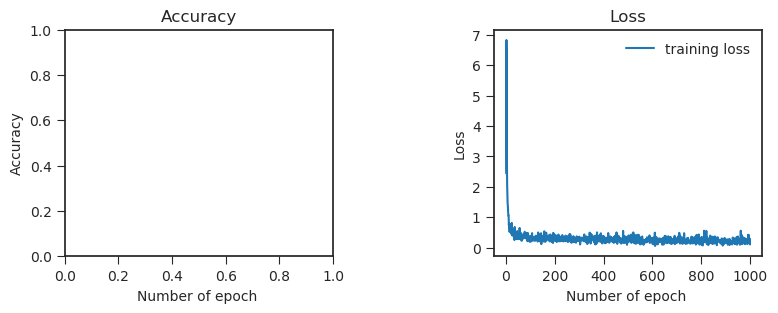

In [41]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss_1'][0],history_train['loss_1'][1])

### Evaluate the  keras to estimator model locally

In [42]:
metric=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(path_test_tfrecords+'*',
                                                                                               FLAGS,
                                                                                               mode=tf.estimator.ModeKeys.EVAL,
                                                                                               batch_size=10000),
                                      steps=1),

I0427 11:12:32.111239 4402439616 model.py:209] input_dataset_fn: EVAL, eval
/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWarning: Creating resources inside a function passed to Dataset.flat_map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return filenames.flat_map(read_one_file)
I0427 11:12:32.156442 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:12:32.278913 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:12:32.310077 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:12:32Z
I0427 11:12:32.418694 4402439616 monitored_session.py:240] Graph was finalized.
W0427 11:12:32.420037 4402439616 deprecation.py:323] From /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1272: checkpoint_exists (from tensorflow.python.training.checkpoint_manageme

In [43]:
metric

({'accuracy': 0.9585, 'loss': 0.1566179, 'global_step': 1000},)

### Train and evaluate the  keras to estimator model locally

In [44]:
#%%time
# Delete both saved and checkpointed models
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

# chcking files that are present
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

    # need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()
# Reset Keras
tf.keras.backend.clear_session()
# Fit the model (using estimator.train and data.Dataset)
mnist_v1.train_and_evaluate(FLAGS, use_keras=True)

I0427 11:12:38.483603 4402439616 keras.py:432] Using the Keras model provided.


using keras model in estimator
keras_baseline_model


I0427 11:12:39.122835 4402439616 estimator.py:205] Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/v2/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c2f00bba8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
I0427 11:12:39.124379 4402439616 estimator_training.py:186] Not using Dis

/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWarning: Creating resources inside a function passed to Dataset.flat_map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return filenames.flat_map(read_one_file)
I0427 11:12:45.901989 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:12:46.053066 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:12:46.080723 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:12:46Z
I0427 11:12:46.161051 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:12:46.163081 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-40
I0427 11:12:46.194831 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:12:46.205646 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:12:47.017863 44024

I0427 11:12:52.209534 4402439616 basic_session_run_hooks.py:597] Saving checkpoints for 90 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0427 11:12:52.339421 4402439616 model.py:209] input_dataset_fn: EVAL, eval
/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWarning: Creating resources inside a function passed to Dataset.flat_map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return filenames.flat_map(read_one_file)
I0427 11:12:52.380397 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:12:52.491366 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:12:52.517639 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:12:52Z
I0427 11:12:52.594928 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:12:52.596989 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/t

I0427 11:12:59.080578 4402439616 estimator.py:2030] Saving dict for global step 130: accuracy = 0.9385, global_step = 130, loss = 0.19799188
I0427 11:12:59.082565 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 130: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-130
I0427 11:12:59.160911 4402439616 basic_session_run_hooks.py:597] Saving checkpoints for 140 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0427 11:12:59.299166 4402439616 model.py:209] input_dataset_fn: EVAL, eval
/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWarning: Creating resources inside a function passed to Dataset.flat_map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return filenames.flat_map(read_one_file)
I0427 11:12:59.339495 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:12:59.450390 4402439616 esti

I0427 11:13:05.221444 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:13:05.232182 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:13:06.046863 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:13:06.063601 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:13:06
I0427 11:13:06.064397 4402439616 estimator.py:2030] Saving dict for global step 180: accuracy = 0.9382, global_step = 180, loss = 0.19563355
I0427 11:13:06.065838 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 180: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-180
I0427 11:13:06.120058 4402439616 basic_session_run_hooks.py:597] Saving checkpoints for 190 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0427 11:13:06.257210 4402439616 model.py:209] input_dataset_fn: EVAL, eval
/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWar

I0427 11:13:11.843389 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:13:11.867831 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:13:11Z
I0427 11:13:11.942909 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:13:11.944816 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-230
I0427 11:13:11.975920 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:13:11.986880 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:13:12.764626 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:13:12.782009 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:13:12
I0427 11:13:12.782856 4402439616 estimator.py:2030] Saving dict for global step 230: accuracy = 0.9377, global_step = 230, loss = 0.21038423
I0427 11:13:12.784502 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 230: results/Models/Mnist/tf_1_12/estimato

I0427 11:13:18.362488 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:13:18.476819 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:13:18.505196 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:13:18Z
I0427 11:13:18.582095 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:13:18.584348 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-280
I0427 11:13:18.616738 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:13:18.627782 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:13:19.452970 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:13:19.469870 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:13:19
I0427 11:13:19.470689 4402439616 estimator.py:2030] Saving dict for global step 280: accuracy = 0.948, global_step = 280, loss = 0.16918574
I0427 11:13:19.472234 4402439616 estimator.py:2090] Saving 'checkpoint_pat

/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWarning: Creating resources inside a function passed to Dataset.flat_map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return filenames.flat_map(read_one_file)
I0427 11:13:25.498260 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:13:25.610237 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:13:25.636339 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:13:25Z
I0427 11:13:25.714466 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:13:25.716310 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-330
I0427 11:13:25.747519 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:13:25.758282 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:13:26.547491 4402

I0427 11:13:31.751399 4402439616 basic_session_run_hooks.py:597] Saving checkpoints for 380 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0427 11:13:31.898532 4402439616 model.py:209] input_dataset_fn: EVAL, eval
/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWarning: Creating resources inside a function passed to Dataset.flat_map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return filenames.flat_map(read_one_file)
I0427 11:13:31.939354 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:13:32.057603 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:13:32.088150 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:13:32Z
I0427 11:13:32.174801 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:13:32.176563 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/

I0427 11:13:38.912061 4402439616 estimator.py:2030] Saving dict for global step 420: accuracy = 0.9534, global_step = 420, loss = 0.15833324
I0427 11:13:38.913054 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 420: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-420
I0427 11:13:38.974981 4402439616 basic_session_run_hooks.py:597] Saving checkpoints for 430 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0427 11:13:39.116935 4402439616 model.py:209] input_dataset_fn: EVAL, eval
/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWarning: Creating resources inside a function passed to Dataset.flat_map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return filenames.flat_map(read_one_file)
I0427 11:13:39.162344 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:13:39.280823 4402439616 esti

I0427 11:13:45.314556 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:13:45.326261 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:13:46.917721 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:13:46.937674 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:13:46
I0427 11:13:46.939979 4402439616 estimator.py:2030] Saving dict for global step 470: accuracy = 0.9549, global_step = 470, loss = 0.1562982
I0427 11:13:46.943650 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 470: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-470
I0427 11:13:47.097228 4402439616 basic_session_run_hooks.py:597] Saving checkpoints for 480 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0427 11:13:47.251477 4402439616 model.py:209] input_dataset_fn: EVAL, eval
/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWarn

I0427 11:13:54.742181 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:13:54.769605 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:13:54Z
I0427 11:13:54.848567 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:13:54.851517 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-520
I0427 11:13:54.884293 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:13:54.895721 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:13:56.056934 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:13:56.076604 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:13:56
I0427 11:13:56.077305 4402439616 estimator.py:2030] Saving dict for global step 520: accuracy = 0.9512, global_step = 520, loss = 0.16471101
I0427 11:13:56.078884 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 520: results/Models/Mnist/tf_1_12/estimato

I0427 11:14:03.943343 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:14:03.973722 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:14:03Z
I0427 11:14:04.057711 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:14:04.059817 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-570
I0427 11:14:04.093556 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:14:04.104081 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:14:05.064294 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:14:05.088688 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:14:05
I0427 11:14:05.089543 4402439616 estimator.py:2030] Saving dict for global step 570: accuracy = 0.9536, global_step = 570, loss = 0.16327854
I0427 11:14:05.091313 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 570: results/Models/Mnist/tf_1_12/estimato

I0427 11:14:11.985116 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:14:12.012069 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:14:12Z
I0427 11:14:12.092371 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:14:12.094329 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-620
I0427 11:14:12.127305 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:14:12.138352 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:14:13.251667 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:14:13.272845 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:14:13
I0427 11:14:13.273618 4402439616 estimator.py:2030] Saving dict for global step 620: accuracy = 0.9521, global_step = 620, loss = 0.17093357
I0427 11:14:13.275114 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 620: results/Models/Mnist/tf_1_12/estimato

I0427 11:14:21.272354 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:14:21.302192 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:14:21Z
I0427 11:14:21.383534 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:14:21.385727 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-670
I0427 11:14:21.416465 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:14:21.426688 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:14:22.330245 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:14:22.349487 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:14:22
I0427 11:14:22.350601 4402439616 estimator.py:2030] Saving dict for global step 670: accuracy = 0.9531, global_step = 670, loss = 0.16220711
I0427 11:14:22.353096 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 670: results/Models/Mnist/tf_1_12/estimato

I0427 11:14:28.486202 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:14:28.512667 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:14:28Z
I0427 11:14:28.588943 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:14:28.590823 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-720
I0427 11:14:28.622053 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:14:28.633583 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:14:29.537364 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:14:29.554917 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:14:29
I0427 11:14:29.556195 4402439616 estimator.py:2030] Saving dict for global step 720: accuracy = 0.9538, global_step = 720, loss = 0.15361658
I0427 11:14:29.557965 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 720: results/Models/Mnist/tf_1_12/estimato

I0427 11:14:35.080950 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:14:35.108237 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:14:35Z
I0427 11:14:35.196906 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:14:35.199807 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-770
I0427 11:14:35.234438 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:14:35.245697 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:14:35.991408 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:14:36.009203 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:14:36
I0427 11:14:36.010168 4402439616 estimator.py:2030] Saving dict for global step 770: accuracy = 0.9566, global_step = 770, loss = 0.15679821
I0427 11:14:36.012925 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 770: results/Models/Mnist/tf_1_12/estimato

I0427 11:14:41.662348 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:14:41.687450 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:14:41Z
I0427 11:14:41.764779 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:14:41.766963 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-820
I0427 11:14:41.798946 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:14:41.809520 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:14:42.599354 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:14:42.617088 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:14:42
I0427 11:14:42.617925 4402439616 estimator.py:2030] Saving dict for global step 820: accuracy = 0.9592, global_step = 820, loss = 0.14676121
I0427 11:14:42.620151 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 820: results/Models/Mnist/tf_1_12/estimato

I0427 11:14:47.947575 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:14:48.064790 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:14:48.091285 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:14:48Z
I0427 11:14:48.173445 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:14:48.175697 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-870
I0427 11:14:48.209107 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:14:48.220093 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:14:48.972918 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 11:14:48.989679 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-11:14:48
I0427 11:14:48.990681 4402439616 estimator.py:2030] Saving dict for global step 870: accuracy = 0.9597, global_step = 870, loss = 0.14592372
I0427 11:14:48.992702 4402439616 estimator.py:2090] Saving 'checkpoint_pa

/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWarning: Creating resources inside a function passed to Dataset.flat_map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return filenames.flat_map(read_one_file)
I0427 11:14:54.740084 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:14:54.852191 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:14:54.878428 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:14:54Z
I0427 11:14:54.956276 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:14:54.958215 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-920
I0427 11:14:54.990041 4402439616 session_manager.py:500] Running local_init_op.
I0427 11:14:55.001587 4402439616 session_manager.py:502] Done running local_init_op.
I0427 11:14:55.758448 4402

I0427 11:15:01.212140 4402439616 basic_session_run_hooks.py:597] Saving checkpoints for 970 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0427 11:15:01.331942 4402439616 model.py:209] input_dataset_fn: EVAL, eval
/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow/python/data/ops/readers.py:81: UserWarning: Creating resources inside a function passed to Dataset.flat_map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  return filenames.flat_map(read_one_file)
I0427 11:15:01.375380 4402439616 estimator.py:1138] Calling model_fn.
I0427 11:15:01.486671 4402439616 estimator.py:1140] Done calling model_fn.
I0427 11:15:01.512663 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T11:15:01Z
I0427 11:15:01.591926 4402439616 monitored_session.py:240] Graph was finalized.
I0427 11:15:01.594101 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/

In [45]:
# checking files that are present
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/v2/ckpt/keras
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/graph.pbtxt
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.index


### Visualize the keras to estimator model train/eval

In [46]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard  --logdir   {FLAGS.model_dir} --port 6022

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [47]:
from google.protobuf import text_format


# Let's read our pbtxt file into a Graph protobuf
f = open(FLAGS.model_dir+'graph.pbtxt', "r")
graph_protobuf = text_format.Parse(f.read(), tf.compat.v1.GraphDef())

# Import the graph protobuf into our new graph.
graph_clone = tf.Graph()
with graph_clone.as_default():
    tf.import_graph_def(graph_def=graph_protobuf, name="")

# Display the graph inline.
graph_clone.as_graph_def()

node {
  name: "global_step/Initializer/zeros"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT64
        tensor_shape {
        }
        int64_val: 0
      }
    }
  }
}
node {
  name: "global_step"
  op: "VarHandleOp"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: "global_step"
    }
  }
}
node {
  name: "global_step/IsInitialized/VarIsInitializedOp"
  op: "VarIsInitializedOp"
  input: "global_step"
}
node {
  name: "global_step/Assign"
  op: "AssignVariableOp"
  input: "glo

In [48]:
# Bug TF 2.0, no events produced
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
#history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_train)
    #print(history_eval.keys())
    #print('number of entry for train:', len(history_train['loss_1']))
    #print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
#ml_utils.plot_acc_loss(None, None,
#                       None, None,
#                       history_eval['loss'][0],history_eval['loss'][1],
#                       history_eval['accuracy'][0],history_eval['accuracy'][1])



keras
checkpoint
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.meta
model.ckpt-990.index
graph.pbtxt
model.ckpt-990.data-00000-of-00001
model.ckpt-980.meta
model.ckpt-990.meta
model.ckpt-980.data-00000-of-00001
model.ckpt-980.index
model.ckpt-1000.index


dict_keys([])
{}






### Predict using the  keras to estimator model locally

### Train and evaluate the estimator model with keras layers locally

In [61]:
%%time
# Bug TF 2.0
# comment out exporter because of thie issue https://github.com/tensorflow/tensorflow/issues/27345

logging.set_verbosity(logging.DEBUG)
# Delete both saved and checkpointed models
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)
# need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()
# Reset Keras
tf.keras.backend.clear_session()

# Fit the model (using estimator.train and data.Dataset)
mnist_v1.train_and_evaluate(FLAGS, use_keras=False)

logging.set_verbosity(logging.INFO)

I0427 13:25:06.949253 4402439616 estimator.py:205] Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/v2/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c51a93860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
I0427 13:25:06.950649 4402439616 estimator_training.py:186] Not using Dis

using keras layer and estimator (recommended way)
exporter <tensorflow_estimator.python.estimator.exporter.LatestExporter object at 0x1c51a93dd8>
model based on keras layer but return an estimator model


I0427 13:25:07.343125 4402439616 estimator.py:1140] Done calling model_fn.
I0427 13:25:07.345526 4402439616 basic_session_run_hooks.py:532] Create CheckpointSaverHook.


step 7
step 8


I0427 13:25:07.452536 4402439616 monitored_session.py:240] Graph was finalized.
I0427 13:25:07.536742 4402439616 session_manager.py:500] Running local_init_op.
I0427 13:25:07.547549 4402439616 session_manager.py:502] Done running local_init_op.
I0427 13:25:07.824618 4402439616 basic_session_run_hooks.py:597] Saving checkpoints for 0 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0427 13:25:08.141636 4402439616 basic_session_run_hooks.py:253] loss = 2.304624, step = 0
I0427 13:25:08.858935 4402439616 basic_session_run_hooks.py:251] loss = 1.617451, step = 0 (0.717 sec)
I0427 13:25:09.393231 4402439616 basic_session_run_hooks.py:251] loss = 1.6546074, step = 0 (0.534 sec)
I0427 13:25:09.937989 4402439616 basic_session_run_hooks.py:251] loss = 1.6666449, step = 0 (0.545 sec)
I0427 13:25:10.513521 4402439616 basic_session_run_hooks.py:251] loss = 1.5732439, step = 0 (0.576 sec)
I0427 13:25:11.054641 4402439616 basic_session_run_hooks.py:251] loss = 1.533845, step = 0 (0.5

I0427 13:26:07.022246 4402439616 basic_session_run_hooks.py:251] loss = 1.4780688, step = 0 (1.155 sec)
I0427 13:26:08.136211 4402439616 basic_session_run_hooks.py:251] loss = 1.4613937, step = 0 (1.114 sec)
I0427 13:26:09.155884 4402439616 basic_session_run_hooks.py:251] loss = 1.4849651, step = 0 (1.020 sec)
I0427 13:26:10.229974 4402439616 basic_session_run_hooks.py:251] loss = 1.4792647, step = 0 (1.074 sec)
I0427 13:26:11.306874 4402439616 basic_session_run_hooks.py:251] loss = 1.480066, step = 0 (1.077 sec)
I0427 13:26:12.464381 4402439616 basic_session_run_hooks.py:251] loss = 1.4845839, step = 0 (1.157 sec)
I0427 13:26:13.569784 4402439616 basic_session_run_hooks.py:251] loss = 1.4830297, step = 0 (1.105 sec)
I0427 13:26:14.641998 4402439616 basic_session_run_hooks.py:251] loss = 1.4870348, step = 0 (1.072 sec)
I0427 13:26:15.731755 4402439616 basic_session_run_hooks.py:251] loss = 1.4650235, step = 0 (1.090 sec)
I0427 13:26:16.916296 4402439616 basic_session_run_hooks.py:251] 

I0427 13:27:20.986626 4402439616 basic_session_run_hooks.py:251] loss = 1.4767761, step = 0 (0.770 sec)
I0427 13:27:21.671350 4402439616 basic_session_run_hooks.py:251] loss = 1.4879534, step = 0 (0.685 sec)
I0427 13:27:22.344897 4402439616 basic_session_run_hooks.py:251] loss = 1.4686773, step = 0 (0.674 sec)
I0427 13:27:23.200996 4402439616 basic_session_run_hooks.py:251] loss = 1.4979484, step = 0 (0.856 sec)
I0427 13:27:23.953193 4402439616 basic_session_run_hooks.py:251] loss = 1.4766657, step = 0 (0.752 sec)
I0427 13:27:24.845695 4402439616 basic_session_run_hooks.py:251] loss = 1.4768928, step = 0 (0.892 sec)
I0427 13:27:25.570062 4402439616 basic_session_run_hooks.py:251] loss = 1.4740936, step = 0 (0.724 sec)
I0427 13:27:26.216965 4402439616 basic_session_run_hooks.py:251] loss = 1.474655, step = 0 (0.647 sec)
I0427 13:27:26.856611 4402439616 basic_session_run_hooks.py:251] loss = 1.4689502, step = 0 (0.640 sec)
I0427 13:27:27.531338 4402439616 basic_session_run_hooks.py:251] 

I0427 13:28:24.746842 4402439616 basic_session_run_hooks.py:251] loss = 1.4611516, step = 0 (0.895 sec)
I0427 13:28:25.500997 4402439616 basic_session_run_hooks.py:251] loss = 1.4841996, step = 0 (0.754 sec)
I0427 13:28:26.358877 4402439616 basic_session_run_hooks.py:251] loss = 1.4689618, step = 0 (0.858 sec)
I0427 13:28:27.131255 4402439616 basic_session_run_hooks.py:251] loss = 1.484746, step = 0 (0.772 sec)
I0427 13:28:27.933904 4402439616 basic_session_run_hooks.py:251] loss = 1.4920175, step = 0 (0.803 sec)
I0427 13:28:28.767942 4402439616 basic_session_run_hooks.py:251] loss = 1.5074346, step = 0 (0.834 sec)
I0427 13:28:29.638853 4402439616 basic_session_run_hooks.py:251] loss = 1.4718432, step = 0 (0.871 sec)
I0427 13:28:30.375355 4402439616 basic_session_run_hooks.py:251] loss = 1.4767765, step = 0 (0.737 sec)
I0427 13:28:31.207965 4402439616 basic_session_run_hooks.py:251] loss = 1.4689876, step = 0 (0.833 sec)
I0427 13:28:31.999749 4402439616 basic_session_run_hooks.py:251] 

I0427 13:29:39.060874 4402439616 basic_session_run_hooks.py:251] loss = 1.4923769, step = 0 (0.716 sec)
I0427 13:29:39.782805 4402439616 basic_session_run_hooks.py:251] loss = 1.476454, step = 0 (0.722 sec)
I0427 13:29:40.436046 4402439616 basic_session_run_hooks.py:251] loss = 1.4767754, step = 0 (0.653 sec)
I0427 13:29:41.101658 4402439616 basic_session_run_hooks.py:251] loss = 1.4844035, step = 0 (0.666 sec)
I0427 13:29:41.832596 4402439616 basic_session_run_hooks.py:251] loss = 1.4853213, step = 0 (0.731 sec)
I0427 13:29:43.284129 4402439616 basic_session_run_hooks.py:251] loss = 1.4689628, step = 0 (1.452 sec)
I0427 13:29:44.990897 4402439616 basic_session_run_hooks.py:251] loss = 1.4833994, step = 0 (1.707 sec)
I0427 13:29:46.626883 4402439616 basic_session_run_hooks.py:251] loss = 1.486207, step = 0 (1.636 sec)
I0427 13:29:48.189363 4402439616 basic_session_run_hooks.py:251] loss = 1.4681722, step = 0 (1.562 sec)
I0427 13:29:49.452613 4402439616 basic_session_run_hooks.py:251] l

I0427 13:30:50.175259 4402439616 basic_session_run_hooks.py:251] loss = 1.4924003, step = 0 (0.776 sec)
I0427 13:30:51.659384 4402439616 basic_session_run_hooks.py:251] loss = 1.4767754, step = 0 (1.484 sec)
I0427 13:30:52.956378 4402439616 basic_session_run_hooks.py:251] loss = 1.4689629, step = 0 (1.297 sec)
I0427 13:30:53.989178 4402439616 basic_session_run_hooks.py:251] loss = 1.4710376, step = 0 (1.033 sec)
I0427 13:30:54.958532 4402439616 basic_session_run_hooks.py:251] loss = 1.4766369, step = 0 (0.969 sec)
I0427 13:30:55.778863 4402439616 basic_session_run_hooks.py:251] loss = 1.4689635, step = 0 (0.820 sec)
I0427 13:30:56.697255 4402439616 basic_session_run_hooks.py:251] loss = 1.4689491, step = 0 (0.918 sec)
I0427 13:30:57.611280 4402439616 basic_session_run_hooks.py:251] loss = 1.4845879, step = 0 (0.914 sec)
I0427 13:30:58.746470 4402439616 basic_session_run_hooks.py:251] loss = 1.4690034, step = 0 (1.135 sec)
I0427 13:30:59.832571 4402439616 basic_session_run_hooks.py:251]

I0427 13:31:50.317159 4402439616 basic_session_run_hooks.py:251] loss = 1.4689629, step = 0 (0.638 sec)
I0427 13:31:50.994009 4402439616 basic_session_run_hooks.py:251] loss = 1.4751134, step = 0 (0.677 sec)
I0427 13:31:51.536936 4402439616 basic_session_run_hooks.py:251] loss = 1.4767754, step = 0 (0.543 sec)
I0427 13:31:52.067201 4402439616 basic_session_run_hooks.py:251] loss = 1.4689629, step = 0 (0.530 sec)
I0427 13:31:52.629360 4402439616 basic_session_run_hooks.py:251] loss = 1.4770293, step = 0 (0.562 sec)
I0427 13:31:53.293663 4402439616 basic_session_run_hooks.py:251] loss = 1.4689629, step = 0 (0.664 sec)
I0427 13:31:54.015674 4402439616 basic_session_run_hooks.py:251] loss = 1.4768181, step = 0 (0.722 sec)
I0427 13:31:54.731855 4402439616 basic_session_run_hooks.py:251] loss = 1.4923985, step = 0 (0.716 sec)
I0427 13:31:55.445583 4402439616 basic_session_run_hooks.py:251] loss = 1.4772793, step = 0 (0.714 sec)
I0427 13:31:56.118370 4402439616 basic_session_run_hooks.py:251]

I0427 13:32:39.426808 4402439616 basic_session_run_hooks.py:251] loss = 1.4689629, step = 0 (0.549 sec)
I0427 13:32:39.999844 4402439616 basic_session_run_hooks.py:251] loss = 1.4857007, step = 0 (0.573 sec)
I0427 13:32:40.561197 4402439616 basic_session_run_hooks.py:251] loss = 1.4611504, step = 0 (0.561 sec)
I0427 13:32:41.134000 4402439616 basic_session_run_hooks.py:251] loss = 1.4611505, step = 0 (0.573 sec)
I0427 13:32:41.718875 4402439616 basic_session_run_hooks.py:251] loss = 1.4689643, step = 0 (0.585 sec)
I0427 13:32:42.316708 4402439616 basic_session_run_hooks.py:251] loss = 1.4611504, step = 0 (0.598 sec)
I0427 13:32:42.969474 4402439616 basic_session_run_hooks.py:251] loss = 1.4767754, step = 0 (0.653 sec)
I0427 13:32:43.535329 4402439616 basic_session_run_hooks.py:251] loss = 1.477004, step = 0 (0.566 sec)
I0427 13:32:44.070139 4402439616 basic_session_run_hooks.py:251] loss = 1.4929838, step = 0 (0.535 sec)
I0427 13:32:44.624294 4402439616 basic_session_run_hooks.py:251] 

I0427 13:33:28.073570 4402439616 basic_session_run_hooks.py:251] loss = 1.4767754, step = 0 (0.507 sec)
I0427 13:33:28.623397 4402439616 basic_session_run_hooks.py:251] loss = 1.4688246, step = 0 (0.550 sec)
I0427 13:33:29.155068 4402439616 basic_session_run_hooks.py:251] loss = 1.4767869, step = 0 (0.532 sec)
I0427 13:33:29.659392 4402439616 basic_session_run_hooks.py:251] loss = 1.4611504, step = 0 (0.504 sec)
I0427 13:33:30.169337 4402439616 basic_session_run_hooks.py:251] loss = 1.4689629, step = 0 (0.510 sec)
I0427 13:33:30.716178 4402439616 basic_session_run_hooks.py:251] loss = 1.477207, step = 0 (0.547 sec)
I0427 13:33:31.360344 4402439616 basic_session_run_hooks.py:251] loss = 1.4767754, step = 0 (0.644 sec)
I0427 13:33:31.946149 4402439616 basic_session_run_hooks.py:251] loss = 1.4625304, step = 0 (0.586 sec)
I0427 13:33:32.492949 4402439616 basic_session_run_hooks.py:251] loss = 1.4767754, step = 0 (0.547 sec)
I0427 13:33:33.087024 4402439616 basic_session_run_hooks.py:251] 

I0427 13:34:13.519472 4402439616 basic_session_run_hooks.py:251] loss = 1.5002129, step = 0 (0.634 sec)
I0427 13:34:14.035866 4402439616 basic_session_run_hooks.py:251] loss = 1.4845879, step = 0 (0.516 sec)
I0427 13:34:14.547127 4402439616 basic_session_run_hooks.py:251] loss = 1.4845879, step = 0 (0.511 sec)
I0427 13:34:15.078236 4402439616 basic_session_run_hooks.py:251] loss = 1.4692447, step = 0 (0.531 sec)
I0427 13:34:15.593250 4402439616 basic_session_run_hooks.py:251] loss = 1.4689629, step = 0 (0.515 sec)
I0427 13:34:16.138037 4402439616 basic_session_run_hooks.py:251] loss = 1.4689629, step = 0 (0.545 sec)
I0427 13:34:16.647503 4402439616 basic_session_run_hooks.py:251] loss = 1.4689629, step = 0 (0.509 sec)
I0427 13:34:17.145874 4402439616 basic_session_run_hooks.py:251] loss = 1.4845958, step = 0 (0.498 sec)
I0427 13:34:17.669291 4402439616 basic_session_run_hooks.py:251] loss = 1.5001544, step = 0 (0.523 sec)
I0427 13:34:18.203052 4402439616 basic_session_run_hooks.py:251]

I0427 13:34:58.470822 4402439616 basic_session_run_hooks.py:251] loss = 1.4611504, step = 0 (0.500 sec)
I0427 13:34:59.007836 4402439616 basic_session_run_hooks.py:251] loss = 1.4767754, step = 0 (0.537 sec)
I0427 13:34:59.634752 4402439616 basic_session_run_hooks.py:251] loss = 1.4689629, step = 0 (0.627 sec)
I0427 13:35:00.228064 4402439616 basic_session_run_hooks.py:251] loss = 1.476775, step = 0 (0.593 sec)
I0427 13:35:00.862843 4402439616 basic_session_run_hooks.py:251] loss = 1.4845879, step = 0 (0.635 sec)
I0427 13:35:01.377789 4402439616 basic_session_run_hooks.py:251] loss = 1.4767754, step = 0 (0.515 sec)
I0427 13:35:01.917238 4402439616 basic_session_run_hooks.py:251] loss = 1.4830602, step = 0 (0.539 sec)
I0427 13:35:02.495958 4402439616 basic_session_run_hooks.py:251] loss = 1.4687108, step = 0 (0.579 sec)
I0427 13:35:03.063512 4402439616 basic_session_run_hooks.py:251] loss = 1.4767754, step = 0 (0.568 sec)
I0427 13:35:03.621870 4402439616 basic_session_run_hooks.py:251] 

I0427 13:35:53.365542 4402439616 basic_session_run_hooks.py:251] loss = 1.4845879, step = 0 (0.620 sec)
I0427 13:35:53.943055 4402439616 basic_session_run_hooks.py:251] loss = 1.4611506, step = 0 (0.578 sec)
I0427 13:35:54.498384 4402439616 basic_session_run_hooks.py:251] loss = 1.4845879, step = 0 (0.555 sec)
I0427 13:35:55.058319 4402439616 basic_session_run_hooks.py:251] loss = 1.5002129, step = 0 (0.560 sec)
I0427 13:35:55.585765 4402439616 basic_session_run_hooks.py:251] loss = 1.4832158, step = 0 (0.527 sec)
I0427 13:35:56.112159 4402439616 basic_session_run_hooks.py:251] loss = 1.4613, step = 0 (0.526 sec)
I0427 13:35:56.650241 4402439616 basic_session_run_hooks.py:251] loss = 1.461159, step = 0 (0.538 sec)
I0427 13:35:57.223569 4402439616 basic_session_run_hooks.py:251] loss = 1.4845879, step = 0 (0.573 sec)
I0427 13:35:57.754630 4402439616 basic_session_run_hooks.py:251] loss = 1.4689629, step = 0 (0.531 sec)
I0427 13:35:58.291982 4402439616 basic_session_run_hooks.py:251] los

model based on keras layer but return an estimator model


I0427 13:36:33.560808 4402439616 estimator.py:1140] Done calling model_fn.
I0427 13:36:33.591524 4402439616 evaluation.py:255] Starting evaluation at 2019-04-27T13:36:33Z
I0427 13:36:33.669581 4402439616 monitored_session.py:240] Graph was finalized.
I0427 13:36:33.671360 4402439616 saver.py:1276] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-0
I0427 13:36:33.723891 4402439616 session_manager.py:500] Running local_init_op.
I0427 13:36:33.736160 4402439616 session_manager.py:502] Done running local_init_op.
I0427 13:36:34.522156 4402439616 evaluation.py:167] Evaluation [1/1]
I0427 13:36:34.537989 4402439616 evaluation.py:275] Finished evaluation at 2019-04-27-13:36:34
I0427 13:36:34.538946 4402439616 estimator.py:2030] Saving dict for global step 0: accuracy = 0.0864, global_step = 0, loss = 2.3051455
I0427 13:36:34.541981 4402439616 estimator.py:2090] Saving 'checkpoint_path' summary for global step 0: results/Models/Mnist/tf_1_12/estimator/v2/ckpt

TypeError: '_HiddenTfApiAttribute' object is not callable

In [59]:
# checking files that are present
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/v2/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-0.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/graph.pbtxt
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-0.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-0.meta


In [81]:
from google.protobuf import text_format


# Let's read our pbtxt file into a Graph protobuf
f = open(FLAGS.model_dir+'graph.pbtxt', "r")
graph_protobuf = text_format.Parse(f.read(), tf.compat.v1.GraphDef())

# Import the graph protobuf into our new graph.
graph_clone = tf.Graph()
with graph_clone.as_default():
    tf.import_graph_def(graph_def=graph_protobuf, name="")

# Display the graph inline.
graph_clone.as_graph_def()

node {
  name: "global_step/Initializer/zeros"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT64
        tensor_shape {
        }
        int64_val: 0
      }
    }
  }
}
node {
  name: "global_step"
  op: "VarHandleOp"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: "global_step"
    }
  }
}
node {
  name: "global_step/IsInitialized/VarIsInitializedOp"
  op: "VarIsInitializedOp"
  input: "global_step"
}
node {
  name: "global_step/Assign"
  op: "AssignVariableOp"
  input: "glo

### Visualize the estimator model with keras layers locally

In [114]:
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
%tensorboard  --logdir   {FLAGS.model_dir}

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [113]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir)
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])



checkpoint
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.meta
model.ckpt-990.index
graph.pbtxt
model.ckpt-990.data-00000-of-00001
model.ckpt-980.meta
model.ckpt-990.meta
model.ckpt-980.data-00000-of-00001
model.ckpt-980.index
model.ckpt-1000.index


dict_keys([])
dict_keys([])


KeyError: 'loss'

### Train and evaluate the estimator model with keras layers locally with python
do a small test locally to check that the python package is working

In [103]:
%%bash
# Setup python so it sees the task module which controls the model.py
export PYTHONPATH=${PYTHONPATH}:${PWD}/src/model_mnist_v1
python -m trainer.task \
--epoch=2 \
--step_per_epoch=468 \
--input_test_tfrecords='data/mnist/tfrecords_image_test/*' \
--input_train_tfrecords='data/mnist/tfrecords_image_train/*' \
--model_dir='results/Models/Mnist/tf_1_12/estimator/ckpt/' \
--saved_dir='results/Models/Mnist/tf_1_12/estimator/pt/' 

exporter <tensorflow.python.estimator.exporter.LatestExporter object at 0x1c39505898>
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0x1c39505be0>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c39505da0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief'

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553682145.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553682145.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tens

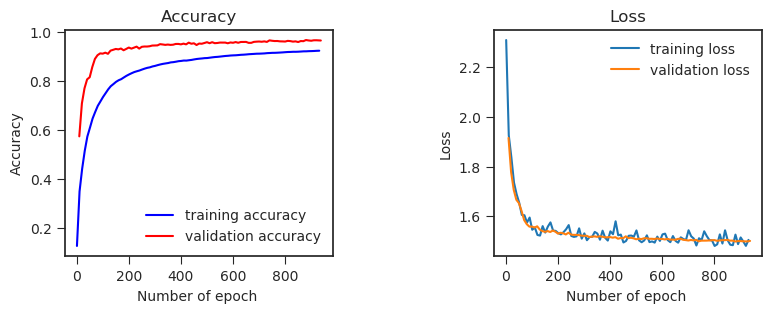

In [104]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Train the model on locally using gcloud

In [109]:
%%bash
# Use Cloud Machine Learning Engine to train the model in local file system
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=${PWD}/src/${MODEL_NAME}/trainer \
   -- \
   --epoch=2 \
   --step_per_epoch=468 \
   --input_test_tfrecords=${PWD}/'data/mnist/tfrecords_image_test/*' \
   --input_train_tfrecords=${PWD}/'data/mnist/tfrecords_image_train/*' \
   --model_dir=${PWD}/'results/Models/Mnist/tf_1_12/estimator/ckpt/' \
   --saved_dir=${PWD}/'results/Models/Mnist/tf_1_12/estimator/pt/' 

exporter <tensorflow.python.estimator.exporter.LatestExporter object at 0x1c32505668>
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 

INFO:tensorflow:TF_CONFIG environment variable: {'environment': 'cloud', 'cluster': {}, 'job': {'args': ['--epoch=2', '--step_per_epoch=468', '--input_test_tfrecords=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/mnist/tfrecords_image_test/*', '--input_train_tfrecords=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/mnist/tfrecords_image_train/*', '--model_dir=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/ckpt/', '--saved_dir=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/pt/'], 'job_name': 'trainer.task'}, 'task': {}}
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:RunConfig initialized for Distribute Coordinator with INDEPENDENT_WORKER mode
INFO:

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553686744.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553686744.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tens

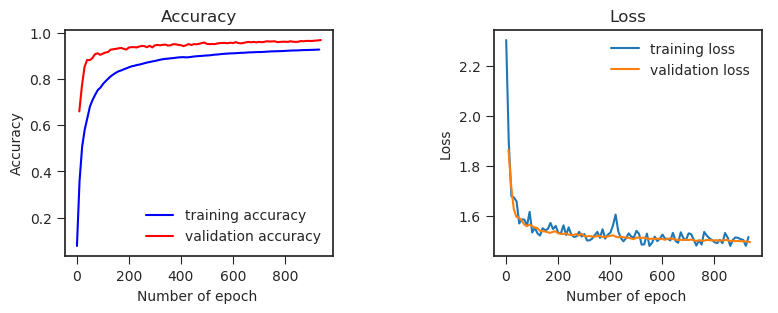

In [110]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Train the model on GCP using gcloud

In [630]:
!gsutil ls gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/

gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-1.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-10.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-2.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-3.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-4.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-5.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-6.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-7.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-8.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-9.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/tfrecord_image_test/
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/tfrecords_image_test/


In [111]:
!pwd

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


In [653]:
%%bash
echo "gs://${PROJECT}/mnist/tfrecords/image_test/"

gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/


In [658]:
%%bash
# Clear Cloud Storage bucket and copy the tfrecords files to Cloud Storage bucket
echo $BUCKET
gsutil -m rm -rf "gs://${BUCKET}/mnist/tfrecords/image_test/"
gsutil -m rm -rf "gs://${BUCKET}/mnist/tfrecords/image_train/"
gsutil -m cp "${PWD}/data/mnist/tfrecords_image_test/*" "gs://${BUCKET}/mnist/tfrecords/image_test/"
gsutil -m cp "${PWD}/data/mnist/tfrecords_image_train/*" "gs://${BUCKET}/mnist/tfrecords/image_train/"

ml-productive-pipeline-53122


Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-1.tfrecords#1553517828053883...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-10.tfrecords#1553517828015615...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-2.tfrecords#1553517827285785...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-3.tfrecords#1553517827539125...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-4.tfrecords#1553517828118894...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-5.tfrecords#1553517827486017...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-6.tfrecords#1553517827901783...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-7.tfrecords#1553517828044041...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-8.tfrecords#1553517827140683...
Removing gs://ml-productive-pipeline

In [696]:
%%bash
OUTDIR="gs://${BUCKET}/${MODEL_NAME}/${TRAINING_DIR}"
JOBNAME=${MODEL_NAME}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
# Clear the Cloud Storage Bucket used for the training job
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/src/${MODEL_NAME}/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket="gs://$BUCKET" \
   --scale-tier=$TIER \
   --runtime-version=$TFVERSION \
   --python-version='3.5' \
   --labels=$RESOURCE_LABELS \
   -- \
   --epoch=2 \
   --step_per_epoch=468 \
   --input_test_tfrecords= "gs://${BUCKET}/mnist/tfrecords/image_test/*" \
   --input_train_tfrecords="gs://${BUCKET}/mnist/tfrecords/image_train/*" \
   --model_dir=$OUTDIR \
   --saved_dir=$OUTDIR   

gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained us-central1 model_mnist_v1_190325_152158
jobId: model_mnist_v1_190325_152158
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [model_mnist_v1_190325_152158] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe model_mnist_v1_190325_152158

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs model_mnist_v1_190325_152158


In [697]:
! gcloud ml-engine jobs stream-logs model_mnist_v1_190325_152158

INFO	2019-03-25 16:22:04 +0100	service		Validating job requirements...
INFO	2019-03-25 16:22:04 +0100	service		Job creation request has been successfully validated.
INFO	2019-03-25 16:22:05 +0100	service		Job model_mnist_v1_190325_152158 is queued.
INFO	2019-03-25 16:22:05 +0100	service		Waiting for job to be provisioned.
INFO	2019-03-25 16:22:08 +0100	service		Waiting for training program to start.
INFO	2019-03-25 16:23:44 +0100	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "package_uris": ["gs://ml-productive-pipeline-53122/model_mnist_v1_190325_152158/c22fca2b0adcf8de1bb4a11353a9ac9cc2f655f4d527462ea4346efc2e3e7a11/model_mnist_v1-0.1.tar.gz"],  "python_module": "trainer.task",  "args": ["--epoch\u003d2", "--step_per_epoch\u003d468", "--input_test_tfrecords\u003d", "gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/*", "--input_train_tfrecords\u003dgs://ml-productive-pipeline-53122/mni

INFO	2019-03-25 16:24:28 +0100	master-replica-0		TF_CONFIG environment variable: {'task': {'cloud': 'qe913eccfb8ab063b-ml', 'index': 0, 'type': 'master'}, 'cluster': {'master': ['127.0.0.1:2222']}, 'environment': 'cloud', 'job': {'runtime_version': '1.12', 'python_module': 'trainer.task', 'package_uris': ['gs://ml-productive-pipeline-53122/model_mnist_v1_190325_152158/c22fca2b0adcf8de1bb4a11353a9ac9cc2f655f4d527462ea4346efc2e3e7a11/model_mnist_v1-0.1.tar.gz'], 'python_version': '3.5', 'job_dir': 'gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained', 'region': 'us-central1', 'run_on_raw_vm': True, 'args': ['--epoch=2', '--step_per_epoch=468', '--input_test_tfrecords=', 'gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/*', '--input_train_tfrecords=gs://ml-productive-pipeline-53122/mnist/tfrecords/image_train/*', '--model_dir=gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained', '--saved_dir=gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained',

INFO	2019-03-25 16:25:09 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:25:09 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:25:15 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527507'/saved_model.pb
INFO	2019-03-25 16:25:19 +0100	master-replica-0		Saving checkpoints for 40 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:25:26
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/mo

INFO	2019-03-25 16:26:26 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:26:26 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-100
INFO	2019-03-25 16:26:26 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:26:26 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:26:31 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527585'/saved_model.pb
INFO	2019-03-25 16:26:34 +0100	master-replica-0		global_step/sec: 1.00519
INFO	2019-03-25 16:26:34 +0100	master-replica-0		loss = 0.31793758, step = 100 (99.484 sec)
INFO	2019-03-25 16:26:34 +0100	master-replica-0		Saving checkpoints for 120 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:26:41 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:26:41

INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-180
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:27:40 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:27:45 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527658'/saved_model.pb
INFO	2019-03-25 16:27:48 

INFO	2019-03-25 16:28:46 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:28:46
INFO	2019-03-25 16:28:46 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:28:46 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-260
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:28:47
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Saving dict for global step 260: accuracy = 0.0, global_step = 260, loss = 0.0
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 260: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-260
INFO	2019-03-25 16:28:48 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:28:48 +0100	master-replica-0		Done calling model_

INFO	2019-03-25 16:29:54 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:29:54
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Saving dict for global step 340: accuracy = 0.0, global_step = 340, loss = 0.0
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 340: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-340
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export 

INFO	2019-03-25 16:30:48 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527844'/saved_model.pb
INFO	2019-03-25 16:30:51 +0100	master-replica-0		global_step/sec: 1.22815
INFO	2019-03-25 16:30:51 +0100	master-replica-0		loss = 0.047065996, step = 400 (81.423 sec)
INFO	2019-03-25 16:30:51 +0100	master-replica-0		Saving checkpoints for 420 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:30:57
INFO	2019-03-25 16:30:58 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:30:58 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/mode

INFO	2019-03-25 16:31:54 +0100	master-replica-0		Saving checkpoints for 500 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:32:00 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:32:01
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-500
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:32:02 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:32:02
INFO	2019-03-25 16:32:02 +0100	master-replica-0		Saving dict for global

INFO	2019-03-25 16:32:49 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:32:53 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527968'/saved_model.pb
INFO	2019-03-25 16:32:56 +0100	master-replica-0		Saving checkpoints for 580 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:33:08 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527984'/saved_model.pb
INFO	2019-03-25 16:33:11 +0100	master-replica-0		Saving checkpoints for 600 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:33:17 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:33:17 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:33:17 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:33:17 +0100	m

INFO	2019-03-25 16:34:02 +0100	master-replica-0		Saving dict for global step 660: accuracy = 0.0, global_step = 660, loss = 0.0
INFO	2019-03-25 16:34:05 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 660: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-660
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Restori

INFO	2019-03-25 16:35:04 +0100	master-replica-0		Saving dict for global step 740: accuracy = 0.0, global_step = 740, loss = 0.0
INFO	2019-03-25 16:35:04 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 740: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-740
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Restori

INFO	2019-03-25 16:36:02 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:36:02
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Saving dict for global step 820: accuracy = 0.0, global_step = 820, loss = 0.0
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 820: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-820
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	20

INFO	2019-03-25 16:37:03 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-900
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:37:08 +0100	master-replica-0		SavedModel written to:

INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-

## Visualization

In [ ]:
#for e in tf.train.summary_iterator('/tmp/mnist_convnet_model/events.out.tfevents.1553025053.Fabien-Tarrades-MacBook-Pro.local'):
for e in tf.train.summary_iterator('results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553024123.Fabien-Tarrades-MacBook-Pro.local'):
    for v in e.summary.value:
        #if v.tag == 'accuracy':
        #print(v.simple_value)
        print(v)

In [736]:
from tensorboard.backend.event_processing import event_accumulator
import numpy as np

def load_data_tensorboard(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}
    
    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []
        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)
        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [739]:
#history_eval=load_data_tensorboard(FLAGS.model_dir+'/eval')
history_train=load_data_tensorboard(FLAGS.model_dir)

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local


In [740]:
history_eval.keys(), history_train.keys()

(dict_keys(['accuracy', 'loss']), dict_keys(['global_step/sec', 'loss_1']))

In [574]:
len(history_train['accuracy_1'][1]), len(history_eval['accuracy'][1]), len(history_train['global_step/sec'][1])

(100, 100, 19)

In [575]:
history_eval['accuracy'][0]

array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000])

In [741]:
history_train['accuracy_1'][0]

KeyError: 'accuracy_1'

Loss:
  - loss [training dataset]: 1.526
  - loss [validation dataset: 1.496

Accuracy:
  - accuracy [training dataset]: 92.73%
  - accuracy [validation dataset: 96.68%


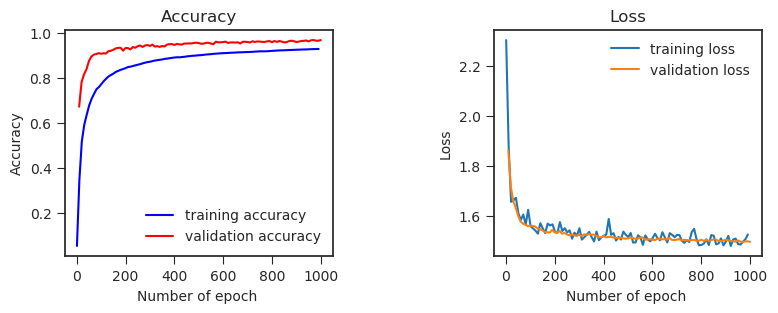

In [577]:
# plot the training loss and accuracy
fig = plt.figure(figsize=(9, 3), dpi=100)
plt.subplots_adjust(wspace=0.6)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(history_train['accuracy_1'][0], history_train['accuracy_1'][1], 'b', label='training accuracy')
ax1.plot(history_eval['accuracy'][0], history_eval['accuracy'][1], 'r', label='validation accuracy');
ax1.set_title('Accuracy')
ax1.set_xlabel("Number of epoch ")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="best")

ax2.plot(history_train['loss'][0], history_train['loss'][1], label="training loss")
ax2.plot(history_eval['loss'][0], history_eval['loss'][1], label="validation loss")
ax2.set_title("Loss")
ax2.set_xlabel("Number of epoch ")
ax2.set_ylabel("Loss")
ax2.legend(loc="best");

print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(history_train['loss'][1][-1]))
print('  - loss [validation dataset: {0:.3f}'.format(history_eval['loss'][1][-1]))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100 * history_train['accuracy_1'][1][-1]))
print('  - accuracy [validation dataset: {:.2f}%'.format(100 * history_eval['accuracy'][1][-1]))

### Check the output created during the training
https://medium.com/@prasadpal107/saving-freezing-optimizing-for-inference-restoring-of-tensorflow-models-b4146deb21b5  
- creating a keras model will create the **keras** folder 
- **checkpoint**, text file that contain all checkpoint information, like model ckpt file name and path
- **model.ckpt-xxx.meta** and **model.ckpt-xxx.data-yyyyy-of-zzzzz** and **model.ckpt-xxx.index** file created for each model  
  .ckpt-xxx.meta contains the complete graph. It includes GraphDef, SaverDef, and so on  
  .ckpt-xxx.data contains the values of variables(weights, biases, placeholders, gradients, hyper-parameters etc)   
  .ckpt-xxx.index is a table where each key is the name of a tensor and its value is a serialized BundleEntryProto 
- **graph.pbtxt** holds a network of nodes, each representing one operation, connected to each other as inputs and outputs (graph structure)
- **events.out.tfevents.xxxxxxxxxx** which contain information that TensorBoard uses to create visualizations

Meta files holds ,more than just the structure of the graph like MetaInfoDef , GraphDef SaverDef , CollectionDef . Whereas .pbtxt files holds only the structure of the graph.

In [100]:
for file in glob.glob(FLAGS.model_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

keras
checkpoint
model.ckpt-940.data-00000-of-00001
model.ckpt-1000.data-00000-of-00001
model.ckpt-920.meta
model.ckpt-940.meta
model.ckpt-1000.meta
model.ckpt-960.meta
events.out.tfevents.1552739145.Fabien-Tarrades-MacBook-Pro.local
graph.pbtxt
model.ckpt-980.meta
model.ckpt-960.data-00000-of-00001
model.ckpt-920.index
model.ckpt-920.data-00000-of-00001
eval
model.ckpt-980.data-00000-of-00001
export
model.ckpt-960.index
model.ckpt-980.index
model.ckpt-940.index
model.ckpt-1000.index


### TensorBoard

In [39]:
print('Tensorflow logs will be saved here:\n',FLAGS.model_dir)

Tensorflow logs will be saved here:
 results/Models/Mnist/tf_1_12/estimator/ckpt/


In [243]:
for file in glob.glob(FLAGS.model_dir+'*events.out.tfevents.*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

events.out.tfevents.1553024123.Fabien-Tarrades-MacBook-Pro.local


In [228]:
tensorboard_command='tensorboard --logdir "'+FLAGS.model_dir+'"'

In [42]:
print('In a separate shell with the same env activated (need Tensoflow and TensorBoard)')
print('  copy and pate the command below without ">>":')
print('  >>',tensorboard_command)


In a separate shell with the same env activated (need Tensoflow and TensorBoard)
  copy and pate the command below without ">>":
  >> tensorboard --logdir "results/Models/Mnist/tf_1_12/estimator/ckpt/"


### Looking at the output of the TimeHistory

In [ ]:
total_time = sum(time_hist.times)
print(f"total time with the current strategy: {total_time} seconds")

In [ ]:
avg_time_per_batch = np.mean(time_hist.times)
print(f"{BATCH_SIZE/avg_time_per_batch} images/second")

## Accuracy and losses

### Training dataset

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(glob.glob(path_train_tfrecords+'/train*.tfrecords'),
                                                                                              FLAGS,
                                                                                              mode=tf.estimator.ModeKeys.TRAIN,
                                                                                              batch_size=FLAGS.batch_size),
                                     steps=1)

In [ ]:
# print test accuracy
print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(score['loss']))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100*score['accuracy']))
print('')
print('Number of steps:')
print('  - number of steps [training dataset]: {}'.format(score['global_step']))

### Testing dataset

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(glob.glob(path_test_tfrecords+'/test*.tfrecords'),
                                                                                              FLAGS,
                                                                                              mode=tf.estimator.ModeKeys.EVAL,
                                                                                              batch_size=FLAGS.batch_size),
                                     steps=1)

In [ ]:
# print test accuracy
print('Loss:')
print('  - loss [testing dataset]: {0:.3f}'.format(score['loss']))
print('')
print('Accuracy:')
print('  - accuracy [testing dataset]: {:.2f}%'.format(100*score['accuracy']))
print('')
print('Number of steps:')
print('  - number of steps [testing dataset]: {}'.format(score['global_step']))

## Test

In [ ]:
# Rebuild the model
predictions = model_fn(features, labels, tf.estimator.ModeKeys.EVAL).predictions

# Manually load the latest checkpoint
saver = tf.train.Saver()
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('/my/directory')
    saver.restore(sess, ckpt.model_checkpoint_path)

    # Loop through the batches and store predictions and labels
    prediction_values = []
    label_values = []
    while True:
        try:
            preds, lbls = sess.run([predictions, labels])
            prediction_values += preds
            label_values += lbls
        except tf.errors.OutOfRangeError:
            break
    # store prediction_values and label_values somewhere

## Prediction 

### Method 1

In [ ]:
testing_dataset = mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                           FLAGS,
                                                           mode=tf.estimator.ModeKeys.EVAL)

In [ ]:
iterator = testing_dataset.make_one_shot_iterator()
# next_element
features, labels = iterator.get_next()

In [ ]:
n=0

n_iter=10
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

In [ ]:
predictions=list(estimator_train_model.predict(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                                                                  FLAGS,
                                                                                                  mode=tf.estimator.ModeKeys.PREDICT)))

In [ ]:
len(predictions), len(x_test)

In [ ]:
output_layer=model_opt_tf.output_names[0]

In [ ]:
for i in range(10):
    prediction_array = predictions[i][output_layer]
    predicted_label = np.argmax(prediction_array)
    print('Actual label:', y_test[i])
    print("Predicted label: ", predicted_label)

### Method 2

In [ ]:
preds_iter=estimator_train_model.predict(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                                                                  FLAGS,
                                                                                                  mode=tf.estimator.ModeKeys.EVAL,
                                                                                                  batch_size=len(x_test)))

In [ ]:
i=0
for pred in list(itertools.islice(preds_iter, 5)):
    prediction_array = pred['dense_2']
    predicted_label = np.argmax(prediction_array)
    print(prediction_array)
    print(i)
    if i==0:
        print('--> ',pred.keys())
    print()
    print('Actual label:', y_test[i])
    print("Predicted label: ", predicted_label)
    i+=1

### Keras's model checks

In [ ]:
model_opt_tf.summary()

In [ ]:
model_opt_tf.input_names

In [ ]:
model_opt_tf.output_names

In [ ]:
output_layer=model_opt_tf.output_names[0]

### Estimator's model checks

In [ ]:
estimator_train_model.get_variable_names()

In [ ]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[0]).shape

In [ ]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[1]).shape

In [ ]:
estimator_train_model.latest_checkpoint()

## Model serving using Keras, tf.estimator and tf.data.dataset

In [ ]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

In [ ]:
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

In [ ]:
model_opt_tf.input_names

In [ ]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders#

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    input_images = tf.placeholder(tf.float32, [None, 784])
    features = {'dense_2_input' : input_images} # this is the dict that is then passed as "features" parameter to your model_fn
    receiver_tensors = {'dense_2_input': input_images} # As far as I understand this is needed to map the input to a name you can retrieve later
   
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [ ]:
if not os.path.exists(FLAGS.saved_dir):
    os.makedirs(FLAGS.saved_dir)

In [ ]:
# Option 2: Only export predict mode
estimator_train_model.export_saved_model(os.path.abspath(FLAGS.saved_dir), 
                                         serving_input_receiver_fn=serving_input_receiver_fn)

In [495]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

**Update the model id in the path below with the correct one from above i.e'1549040172'**

In [504]:
model_tag='1549054852'
os.environ['MODEL_FOR_SERVING']='results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/1553112141'#FLAGS.saved_dir+model_tag+'/'

In [502]:
!ls results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/1553112141

saved_model.pb variables


In [ ]:
# replace the folder name below with the one from above i.e '1549040172'
for file in glob.glob(FLAGS.saved_dir+model_tag+'/*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

## Check the saved model before serving 

In [493]:
tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY,

('serving_default',)

In [505]:
! saved_model_cli show --dir $MODEL_FOR_SERVING --tag serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: Placeholder:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['classes'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: ArgMax:0
  outputs['probabilities'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: Softmax:0
Method name is: tensorflow/serving/predict


## Use Cloud ML Engine

### Checking gcloud installation (SDK)

In [ ]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

### Create a input json file and string

Input needed to get prediction using ml-engine an option --json-instances: 'dense_2_input' for each new entry

In [ ]:
input_prediction=x_test[0:3]

In [ ]:
data = input_prediction.tolist()
json_file = "../data/input_predict_gcloud.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    for el in data:
        instance = {'dense_2_input': el}
        json.dump(instance, f , sort_keys=True)
        f.write("\n")

Input needed to get prediction using ml-engine and cURL

In [ ]:
data = input_prediction.tolist()
json_file = "../data/input_predict_cURL.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    tmp={}
    list_tmp=[]
    for el in data:
        tmp['dense_2_input']=el
        list_tmp.append(tmp)
    instance = {"instances": list_tmp}    
    json.dump(instance, f , sort_keys=True)
    f.write("\n")

In [ ]:
input_predict_request = json.dumps({"signature_name": "serving_default", "instances": input_prediction.tolist()})

display example

In [ ]:
def show(img, title):
    plt.figure()
    plt.imshow(img.reshape(28,28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

In [ ]:
for i in range(1):
    show(x_test[i],'Test dataset, true label: '+str(np.argmax(y_test[i])))

### Test the model inference using gcloud locally

In [ ]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

In [ ]:
!gcloud ml-engine local predict --model-dir $MODEL_FOR_SERVING --json-instances ../data/input_predict_gcloud.json 

### Deploy the model using Cloud ML Engine
- https://cloud.google.com/ml-engine/docs/v1/predict-request
- https://cloud.google.com/ml-engine/docs/tensorflow/online-predict#requesting_predictions

In [ ]:
os.environ['PROJECT']=subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['MODEL']='mnist'
os.environ['BUCKET']='gs://'+os.environ['PROJECT']
os.environ['VERSION']='v2'

In [ ]:
# gsutil need python 2.7
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda/bin/python'

In [ ]:
!gsutil cp -r $MODEL_FOR_SERVING $BUCKET/model_dir_tmp/

In [ ]:
!gcloud ml-engine models list

when creating the model for the first time

create a version and store the model

In [ ]:
!gcloud ml-engine versions create ${VERSION} \
--model ${MODEL} \
--origin=${BUCKET}/model_dir_tmp/1549054852 \
--runtime-version=1.12 \
--staging-bucket=${BUCKET}

#### Checking the list of model in ML-Engine

In [ ]:
!gcloud ml-engine models list

In [ ]:
 !gcloud ml-engine versions list --model mnist

#### Testing our model using ML-Engine

In [ ]:
!gcloud ml-engine predict --model=${MODEL} --version=${VERSION} --json-instances ../data/input_predict_gcloud.json

#### Testing using RESTful API 
- https://www.tensorflow.org/serving/api_rest  
RESTful API is an application program interface (API) that uses HTTP requests to GET, PUT, POST and DELETE data (Json)

Use cURL

In [ ]:
!curl https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION} \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \

In [ ]:
!curl -X POST \
https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION}:predict \
-H "Content-Type: application/json" \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-d @../data/input_predict_cURL.json 

Use python and requests

In [ ]:
url = 'https://ml.googleapis.com/v1/projects/'+os.environ['PROJECT']+'/models/'+os.environ['MODEL']+'/versions/'+os.environ['VERSION']+':predict'

headers = {
    'Content-Type': 'application/json',
    'Authorization':  'Bearer {}'.format(subprocess.run('gcloud auth print-access-token', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', ''))
}

json_response = requests.post(url=url, data=input_predict_request, headers=headers)
json.loads(json_response.text)

In [ ]:
predictions = json.loads(json_response.text)['predictions']

In [ ]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))

#### Testing using gRPC API 
- https://cloud.google.com/endpoints/docs/grpc/about-grpc  
gRPC is a high performance, open-source universal RPC framework, developed by Google. In gRPC, a client application can directly call methods on a server application on a different machine as if it was a local object, making it easier to create distributed applications and services (Protobuf)

In [ ]:
# to do

## Debug Python environment

In [ ]:
!python -c "import tensorflow as tf; print(tf.GIT_VERSION, tf.VERSION)"

In [ ]:
!conda list

In [ ]:
## Reload the model and make evaluation using Keras

In [ ]:
reload_model_opt_keras=tf.keras.models.load_model(FLAGS.model_dir_keras+'keras_model.h5')

In [ ]:
score = reload_model_opt_keras.evaluate(x_train, 
                                        y_train, 
                                        verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
### Evaluate the model using Keras and tf.data.dataset

In [ ]:
score = model_opt_keras.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
score = model_opt_keras.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))